In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from collections import deque
from scipy.special import loggamma, ive
from scipy.stats import vonmises_fisher
from matplotlib.colors import LogNorm
from sklearn.neighbors import NearestNeighbors

plt.rcParams.update({'font.size': 20})

def linear_fit(x, y):
    x_ = x - x.mean()
    y_ = y - y.mean()
    k = (x_ * y_).sum() / (x_ * x_).sum()
    b = y.mean() - k * x.mean()
    return k, b

In [2]:
def expected_log_jacobian(angles):
    assert angles.shape[-1] >= 3
    log_sines = angles[..., 1:-1].sin().log().mean(dim=-2)
    shape = (1, ) * (len(log_sines.shape) - 1) + (-1, )
    mults = torch.arange(angles.shape[-1] - 2, 0, -1).reshape(shape)
    log_jacobian = (log_sines * mults).sum(dim=-1)
    return log_jacobian


def entropy_kozachenko_leonenko(weights, mode='scale', effective_dim=None):
    assert mode in ['isotropic', 'scale', 'covariance']
    N, D = weights.shape[1:]
    dim = D if effective_dim is None else effective_dim
    entropy = []

    for weight in weights:
        normed_weight = weight - weight.mean(dim=0, keepdim=True)
        if mode == 'scale':
            std = normed_weight.std(dim=0, keepdim=True)
            normed_weight = normed_weight / std
        elif mode == 'covariance':
            sigma = normed_weight.T @ normed_weight / (N - 1)
            U, S, V = torch.svd(sigma)
            A = U * (1 / S.sqrt()) @ U.T
            normed_weight = weight @ A

        nb = NearestNeighbors(n_neighbors=2).fit(normed_weight)
        dists, _ = nb.kneighbors(normed_weight)
        value = dim * np.log(dists[..., 1]).mean() + dim / 2 * np.log(np.pi) - loggamma(dim / 2 + 1) + \
                np.log(N - 1) + np.euler_gamma

        if mode == 'scale':
            value += std.log().sum()
        elif mode == 'covariance':
            value += 0.5 * S.log().sum()
        entropy.append(value)

    return torch.tensor(entropy)


def spherical_entropy(weights):
    normalized_weights = weights / weights.norm(dim=-1, keepdim=True)
    angles = sp.to_spherical(normalized_weights)
    angles_ent = entropy_kozachenko_leonenko(angles[..., 1:])
    log_jac = expected_log_jacobian(angles)
    return angles_ent + log_jac


def train(loss_func, lrs, wds, sigmas=None, init_norm=1, dims=10, num_iters=10000, seed=None,
          queue_freq=10, fix_elr=False, fix_sphere=False, queue_size=1000, log_freq=100, ent_log_freq=100000):
    assert len(lrs.shape) == 1
    assert lrs.shape == wds.shape
    assert sigmas is None or lrs.shape == sigmas.shape
    if isinstance(init_norm, torch.Tensor):
        assert lrs.shape == init_norm.shape
    if sigmas is None:
        sigmas = torch.zeros_like(lrs)

    if seed is not None:
        torch.manual_seed(seed)

    weights_queue = deque(maxlen=queue_size)
    loss_queue = deque(maxlen=queue_size)
    x = torch.randn(dims)
    x /= x.norm()
    x = x.reshape(1, -1).repeat(len(lrs), 1)
    if isinstance(init_norm, torch.Tensor):
        x *= init_norm.reshape(-1, 1)
    else:
        x *= init_norm
    x.requires_grad = True

    def calculate_loss_and_grad():
        x.grad = None
        L = loss_func(x)
        L.sum().backward()

        eps = sigmas.reshape(-1, 1) * torch.randn_like(x.data) / x.data.norm(dim=1, keepdim=True)
        eps_proj = eps - (eps * x.data).sum(-1, keepdim=True) / \
                   x.data.square().sum(dim=-1, keepdim=True) * x.data

        return L, eps_proj

    L, eps_proj = calculate_loss_and_grad()
    xs = [x.data.clone()]
    losses = [L.detach().clone()]
    full_grads = [x.grad.clone()]
    stoch_grads = [x.grad.clone() + eps_proj]
    queue_ents, queue_energies, queue_radiuses = [], [], []

    for i in tqdm(range(1, num_iters + 1)):
        L, eps_proj = calculate_loss_and_grad()
        g = x.grad + eps_proj + wds.reshape(-1, 1) * x.data
        if fix_elr:
            step_lrs = lrs.reshape(-1, 1) * x.data.square().sum(-1, keepdim=True)
        else:
            step_lrs = lrs.reshape(-1, 1)
        x.data -=  step_lrs * g

        if i % log_freq == 0:
            xs.append(x.data.clone())
            losses.append(L.detach().clone())
            full_grads.append(x.grad.clone())
            stoch_grads.append(x.grad.clone() + eps_proj)

        if fix_sphere:
            x.data *= init_norm.reshape(-1, 1) / x.data.norm(dim=-1, keepdim=True)

        if i % queue_freq == 0:
            weights_queue.append(x.data.clone())
            loss_queue.append(L.detach().clone())

        if i % ent_log_freq == 0 and len(weights_queue) == queue_size:
            weights = torch.stack(list(weights_queue), dim=1)
            ents = spherical_entropy(weights)
            queue_ents.append(ents)
            queue_energies.append(torch.stack(list(loss_queue), dim=1).mean(dim=1))
            queue_radiuses.append(weights.norm(dim=-1).mean(dim=1))

    xs = torch.stack(xs, dim=0)
    losses = torch.stack(losses, dim=0)
    full_grads = torch.stack(full_grads, dim=0)
    stoch_grads = torch.stack(stoch_grads, dim=0)
    queue_ents = torch.stack(queue_ents, dim=0) if queue_ents else []
    queue_energies = torch.stack(queue_energies, dim=0) if queue_energies else []
    queue_radiuses = torch.stack(queue_radiuses, dim=0) if queue_radiuses else []
    return xs, losses, full_grads, stoch_grads, (queue_ents, queue_energies, queue_radiuses)

# Von Mises-Fisher stationary distribution

## Training with fixed ELR

In [296]:
num_iters = 2000000
ent_log_freq = num_iters // 50
D = 3
queue_size, queue_freq = 1000, 50
sigma = 1
torch.manual_seed(44)
lrs = torch.logspace(-3, -1, 17)
wds = torch.logspace(-3, -1, 17)
lrs_, wds_ = torch.meshgrid(lrs, wds)
lrs_, wds_ = lrs_.reshape(-1), wds_.reshape(-1)
sigmas_ = sigma * torch.ones_like(lrs_)
mu = torch.randn(1, D)
mu /= mu.norm(dim=1, keepdim=True)

In [89]:
trace = train(
    lambda x: 1 + (mu * x).sum(dim=1) / x.norm(dim=1),
    lrs_, wds_, sigmas_, dims=D,
    num_iters=num_iters, init_norm=1,
    queue_size=queue_size, queue_freq=queue_freq,
    log_freq=50, ent_log_freq=ent_log_freq,
    seed=42, fix_elr=True,
)
torch.save(trace, 'trace-VMF-ELR.pt')

  0%|          | 0/2000000 [00:00<?, ?it/s]

In [297]:
trace = torch.load('trace-VMF-ELR.pt')
xs, losses, full_grads, stoch_grads, (entropies, energies, radiuses) = trace

In [298]:
ents_mean = entropies[-10:].mean(0)
rs_mean = xs[-5000:].norm(dim=-1).mean(0)
r = rs_mean.reshape(len(lrs), len(wds))
U = losses[-5000:].mean(0).reshape(len(lrs), len(wds))
S = ents_mean.reshape(len(lrs), len(wds))
S_full = S + (D - 1) * r.log()
V = 0.5 * r ** 2
T = lrs.reshape(-1, 1) * sigma ** 2 / 2
p = wds.reshape(1, -1)

### Comparison to tabular values (loss and entropy)

Text(0.002754228703338166, 0.5, '$S(\\rho_{\\overline{\\bf{w}}})$')

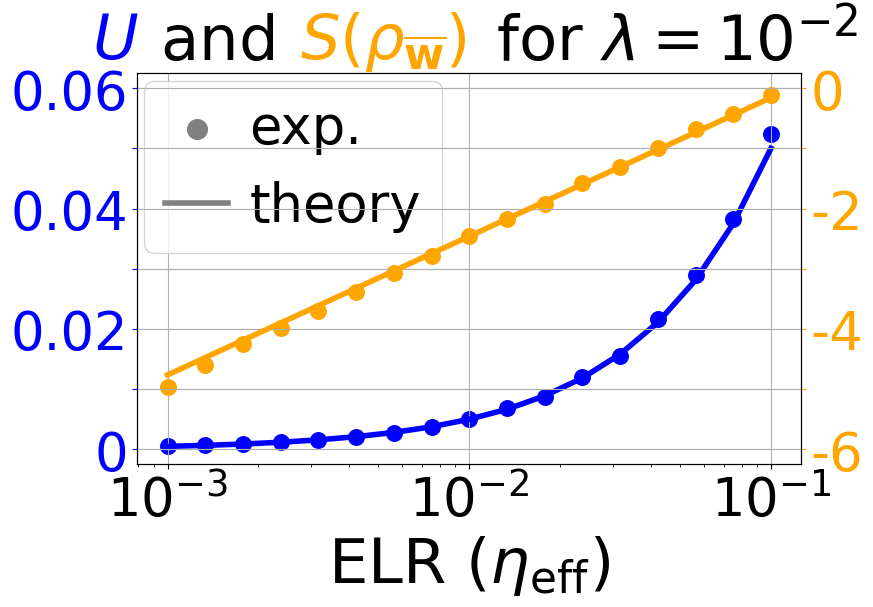

In [299]:
wd_id = 8
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.tight_layout()

ax.scatter(lrs, U[:, wd_id], color='blue', marker='.', s=500, label='exp.')
ax.plot(wds, (D - 1) / 2 * T[:, 0], color='blue', linewidth=4, label=r'theory')

ax2 = ax.twinx()
ax2.scatter(wds, S[:, wd_id], color='orange', marker='.', s=500, label='exp.')
ax2.plot(wds, (D - 1) / 2 * (T[:, 0] * 2 * np.pi * np.e).log(), color='orange',
         linewidth=4, label=r'theory')

ax.set_xscale('log')
ax.set_xlabel(r'ELR ($\eta_{\text{eff}}$)', fontsize=45)
ax.set_xticks([10 ** -3, 10 ** -2, 10 ** -1], ['$10^{-3}$', '$10^{-2}$', '$10^{-1}$'], fontsize=38)
ax.set_yticks([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06], ['0', '', '0.02', '', '0.04', '', '0.06'], fontsize=38)
ax.grid()
ax.tick_params(axis='y', which=u'both', colors='blue')
step = 0.01
ax.set_ylim(0 - step * 0.25, 0.06 + step * 0.25)

ax2.set_yticks([-6, -5, -4, -3, -2, -1, 0], ['-6', '', '-4', '', '-2', '', '0'], fontsize=38)
ax2.grid()
ax2.tick_params(axis='y', which=u'both', colors='orange')
step = 1
ax2.set_ylim(-6 - step * 0.25, 0 + step * 0.25)

ax.scatter([], [], color='gray', s=200, label='exp.')
ax.plot([], [], color='gray', linewidth=4, label='theory')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[-2:], labels=labels[-2:], loc=(0.01, 0.54), fontsize=38,
          handlelength=1.2, handletextpad=0.4)

ax.set_title(r'    and           for $\lambda=10^{-2}$', fontsize=45)
ax2.annotate(xy=(10**-3.25, 0.5), text=r'$U$', fontsize=45, color='blue', annotation_clip=False)
ax2.annotate(xy=(10**-2.56, 0.5), text=r'$S(\rho_{\overline{\bf{w}}})$', fontsize=45, color='orange', annotation_clip=False)
#plt.savefig('images/VMF-ELR-loss-ent.png', dpi=400, bbox_inches='tight')

### Radius prediction

In [300]:
wd_colors = sns.color_palette('viridis', len(lrs) // 2 + 1)
lr_colors = sns.color_palette('plasma', len(lrs) // 2 + 1)

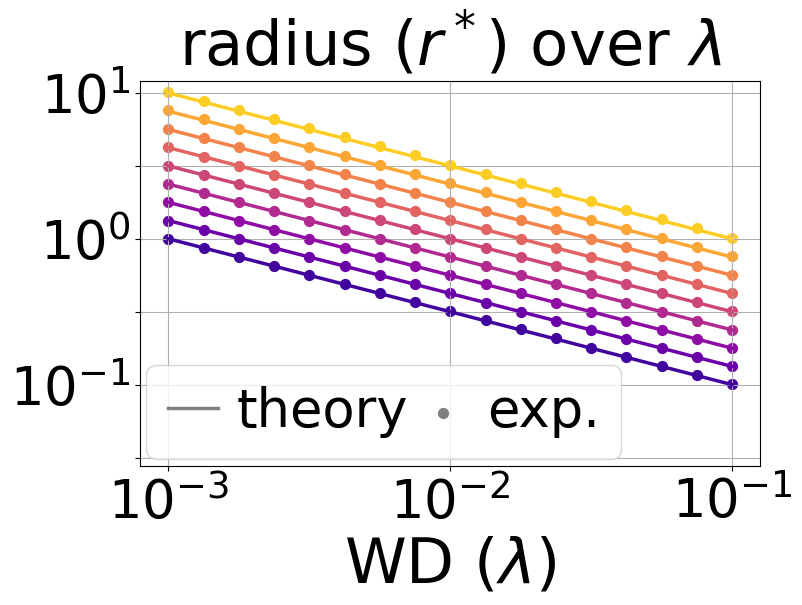

In [301]:
plt.figure(figsize=(8, 5))
plt.tight_layout()

for i in range(0, len(lrs), 2):
    lr = lrs[i]
    T_lr = T[i]
    pred_rs = (T_lr * (D - 1) / wds) ** 0.5
    plt.scatter(wds, r[i], color=lr_colors[i // 2], marker='.', s=200)
    plt.plot(wds, pred_rs, color=lr_colors[i // 2], linestyle='-', linewidth=2.5)

plt.plot([], [], linestyle='-', color='gray', label=r'theory', linewidth=2.5)
plt.scatter([], [], color='gray', marker='.', label='exp.', s=200)
plt.xscale('log')
plt.yscale('log')
#plt.annotate(text=r'$r = \sqrt[4]{\frac{\eta\sigma^2(d-1)}{2\lambda}}$', xy=(1.25e-3, 2))
plt.xticks([1e-3, 1e-2, 1e-1], ['$10^{-3}$', '$10^{-2}$', '$10^{-1}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.yticks([10 ** -1.5, 10 ** -1, 10 ** -0.5, 1, 10 ** 0.5, 10 ** 1], ['', '$10^{-1}$', '', '$10^{0}$', '', '$10^{1}$'], fontsize=38)
plt.yticks([], [], minor=True)
plt.ylim(2.75e-2, 12)
plt.xlabel(r'WD ($\lambda$)', fontsize=45)
plt.title(r'radius ($r^*$) over $\lambda$', fontsize=45, y=1.02)
plt.legend(ncol=2, fontsize=38, loc=(0.01, 0.02),
           columnspacing=0.2, handletextpad=0.35, labelspacing=0.2, handlelength=0.95)
plt.grid()
plt.savefig('images/VMF-ELR-radius.png', dpi=400, bbox_inches='tight')

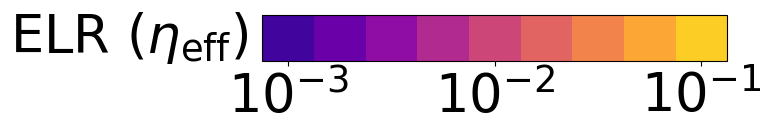

In [307]:
import matplotlib as mpl

cmap = mpl.colors.LinearSegmentedColormap.from_list("custom_plasma", lr_colors, N=len(lr_colors))
fig, ax = plt.subplots(figsize=(6, 0.6))
norm = mpl.colors.Normalize(vmin=0, vmax=len(lr_colors))
cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')
cb.set_ticks([0.5, 4.5, 8.5])
cb.set_ticklabels(['$10^{-3}$', '$10^{-2}$', '$10^{-1}$'], fontsize=38)
cb.set_label('')
ax.text(-0.03, 0.5, r'ELR ($\eta_{\text{eff}}$)', fontsize=38, transform=ax.transAxes,
        rotation=0, va='center', ha='right')

plt.savefig('images/VMF-ELR-legend2.png', dpi=400, bbox_inches='tight')

### Maxwell relations

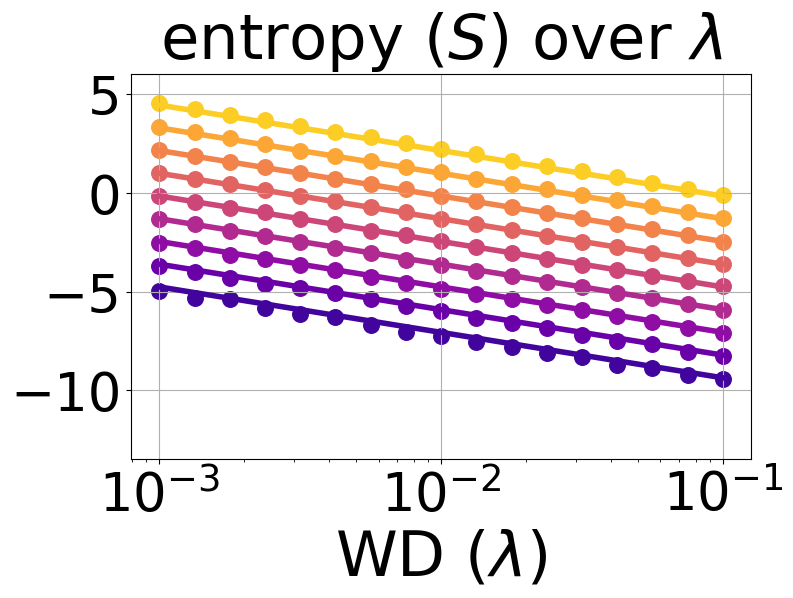

In [302]:
plt.figure(figsize=(8, 5))
plt.tight_layout()

for i in range(0, len(lrs), 2):
    lr = lrs[i]
    T_lr = T[i]
    pred_rs = (T_lr * (D - 1) / wds) ** 0.5
    pred_S = (D - 1) / 2 * (T_lr * 2 * np.pi * np.e).log() + (D - 1) * pred_rs.log()
    plt.scatter(wds, S_full[i], color=lr_colors[i // 2], marker='.', s=500)
    plt.plot(wds, pred_S, color=lr_colors[i // 2], linestyle='-', linewidth=4)

plt.xticks([1e-3, 1e-2, 1e-1], ['$10^{-3}$', '$10^{-2}$', '$10^{-1}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.xlabel(r'WD ($\lambda$)', fontsize=45)
plt.yticks(np.arange(-10, 6, 5), fontsize=38)
plt.yticks([], [], minor=True)
plt.ylim(-13.5, 6)
plt.title(r'entropy ($S$) over $\lambda$', fontsize=45, y=1.02)
plt.xscale('log')
plt.grid()
plt.savefig('images/VMF-ELR-entropy-wd.png', dpi=400, bbox_inches='tight')

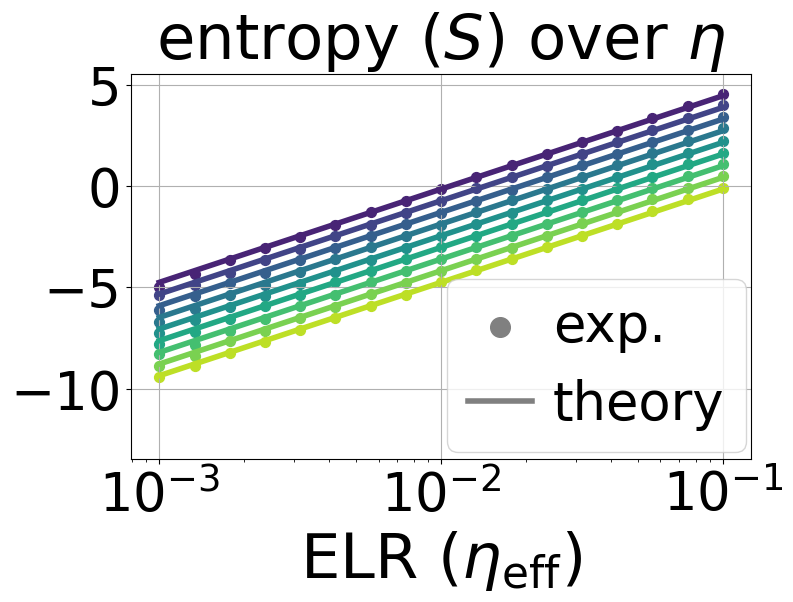

In [303]:
plt.figure(figsize=(8, 5))
plt.tight_layout()

for i in range(0, len(wds), 2):
    wd = wds[i]
    T_wd = T[:, 0]
    pred_rs = (T_wd * (D - 1) / wd) ** 0.5
    pred_S = (D - 1) / 2 * (T_wd * 2 * np.pi * np.e).log() + (D - 1) * pred_rs.log()
    plt.scatter(wds, S_full[:, i], color=wd_colors[i // 2], marker='.', s=200)
    plt.plot(wds, pred_S, color=wd_colors[i // 2], linestyle='-', linewidth=4)

plt.scatter([], [], color='gray', s=200, label='exp.')
plt.plot([], [], color='gray', linewidth=4, label='theory')
plt.legend(fontsize=38, loc=(0.51, 0.02), handlelength=1.2, handletextpad=0.4)
plt.xticks([1e-3, 1e-2, 1e-1], ['$10^{-3}$', '$10^{-2}$', '$10^{-1}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.xlabel(r'ELR ($\eta_{\text{eff}}$)', fontsize=45)
plt.yticks(np.arange(-10, 6, 5), fontsize=38)
plt.ylim(-13.5, 5.5)
plt.yticks([], [], minor=True)
plt.title(r'entropy ($S$) over $\eta$', fontsize=45, y=1.02)
plt.xscale('log')
plt.grid()
plt.savefig('images/VMF-ELR-entropy-lr.png', dpi=400, bbox_inches='tight')

In [304]:
tau_coefs = torch.tensor([linear_fit(wds.log(), S_full[i])[0].item() for i in range(len(lrs))])
tau_coefs.mean(), tau_coefs.std(), -(D - 1) / 2

(tensor(-0.9989), tensor(0.0052), -1.0)

### Gibbs potential minimization

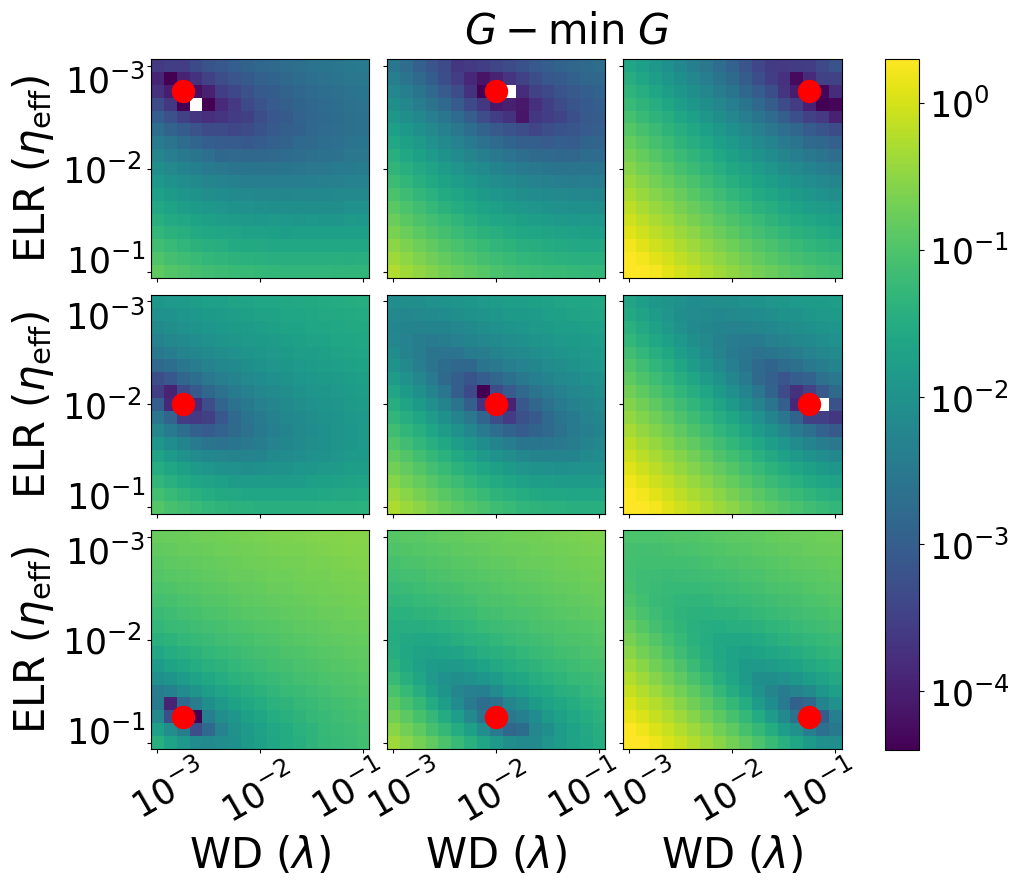

In [305]:
lr_ids, wd_ids = [2, len(lrs) // 2, len(lrs) - 3], [2, len(wds) // 2, len(wds) - 3]
fig, axs = plt.subplots(len(lr_ids), len(wd_ids), figsize=(10, 8), sharex=True, sharey=True)
plt.tight_layout()
plt.subplots_adjust(wspace=0.08, hspace=0.07)

for i, lr_id in enumerate(lr_ids):
    for j, wd_id in enumerate(wd_ids):
        G = U - T[lr_id, 0] * S_full + p[0, wd_id] * V
        cm = axs[i, j].imshow(G - G.min(), norm=LogNorm(vmin=4e-5, vmax=2), cmap='viridis')
        axs[i, j].scatter(wd_id, lr_id, color='red', marker='o', s=250)
        #circle = plt.Circle((wd_id, lr_id), 1.5, edgecolor='red', facecolor='none', linewidth=5)
        #axs[i, j].add_artist(circle)

        step = 4
        ticks_lrs = lrs.tolist()[::step]
        ticks_wds = wds.tolist()[::step]
        #axs[i, 0].set_yticks(np.arange(0, len(lrs), step), [f'{lr:.0e}'.replace('e-0', 'e-') for lr in ticks_lrs], fontsize=20)
        #axs[-1, j].set_xticks(np.arange(0, len(wds), step), [f'{wd:.0e}'.replace('e-0', 'e-') for wd in ticks_wds], fontsize=20, rotation=60)
        axs[i, 0].set_yticks([0, 8, 16], ['', '$10^{-2}$', ''], fontsize=25)
        axs[i, 0].set_yticks([1, 15], ['$10^{-3}$', '$10^{-1}$'], minor=True, fontsize=25)
        axs[-1, j].set_xticks([0, 8, 16], ['', '$10^{-2}$', ''], fontsize=25, rotation=30)
        axs[-1, j].set_xticks([1, 15], ['$10^{-3}$', '$10^{-1}$'], minor=True, fontsize=25, rotation=30)

        axs[i, 0].set_ylabel(r'ELR ($\eta_{\text{eff}}$)', fontsize=30)
        axs[-1, j].set_xlabel(r'WD ($\lambda$)', fontsize=30)
        axs[i, j].tick_params(axis=u'both', which=u'minor', length=0)
        axs[i, j].tick_params(axis=u'both', which=u'major', length=3)

plt.suptitle(r'$G - \min \; G$', y=1.01, fontsize=30)
cbar = fig.colorbar(cm, ax=axs, location='right')
cbar.ax.tick_params(labelsize=25)
cbar.ax.yaxis.set_ticks([], minor=True)
plt.savefig('images/VMF-ELR-potential.png', dpi=400, bbox_inches='tight')

## Training with fixed LR

In [283]:
num_iters = 2000000
ent_log_freq = num_iters // 50
D = 3
queue_size, queue_freq = 1000, 50
sigma = 1
torch.manual_seed(44)
lrs = torch.logspace(-3, -1, 17)
wds = torch.logspace(-3, -1, 17)
lrs_, wds_ = torch.meshgrid(lrs, wds)
lrs_, wds_ = lrs_.reshape(-1), wds_.reshape(-1)
sigmas_ = sigma * torch.ones_like(lrs_)
mu = torch.randn(1, D)
mu /= mu.norm(dim=1, keepdim=True)

In [ ]:
trace = train(
    lambda x: 1 + (mu * x).sum(dim=1) / x.norm(dim=1),
    lrs_, wds_, sigmas_, dims=D,
    num_iters=num_iters, init_norm=1,
    queue_size=queue_size, queue_freq=queue_freq,
    log_freq=50, ent_log_freq=ent_log_freq,
    seed=42, fix_elr=False,
)
torch.save(trace, 'trace-VMF-LR.pt')

In [285]:
trace = torch.load('trace-VMF-LR.pt')
xs, losses, full_grads, stoch_grads, (entropies, energies, radiuses) = trace

In [286]:
ents_mean = entropies[-10:].mean(0)
rs_mean = xs[-5000:].norm(dim=-1).mean(0)
r = rs_mean.reshape(len(lrs), len(wds))
U = losses[-5000:].mean(0).reshape(len(lrs), len(wds))
S = ents_mean.reshape(len(lrs), len(wds))
S_full = S + (D - 1) * r.log()
V = 0.5 * r ** 2
T = torch.sqrt(lrs.reshape(-1, 1) * wds.reshape(1, -1) * sigma ** 2 / 2 / (D - 1))
p = wds.reshape(1, -1)

### Comparison to tabular values (loss and entropy)

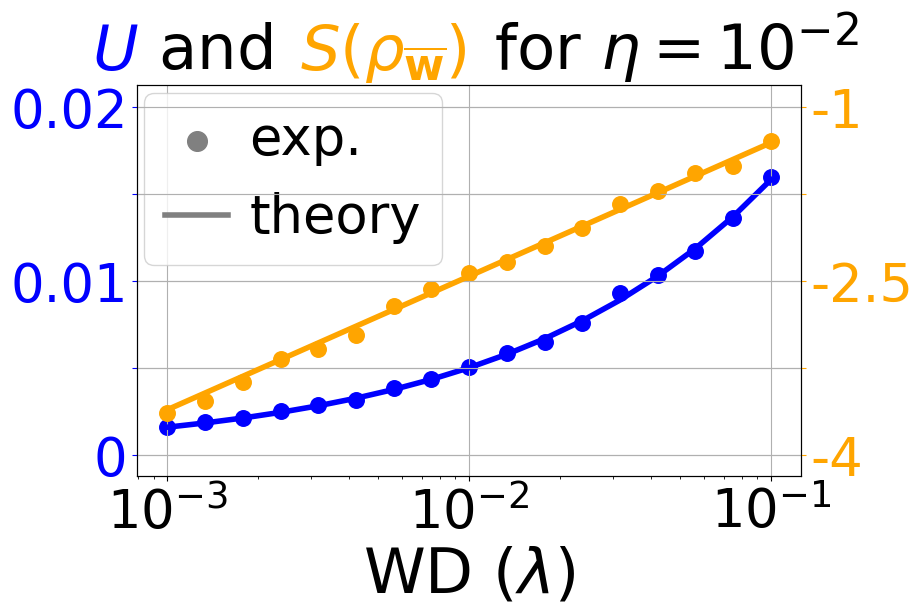

In [287]:
lr_id = 8
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.tight_layout()

lr = lrs[lr_id]
T_lr = T[lr_id]
ax.scatter(wds, U[lr_id], color='blue', marker='.', s=500, label='exp.')
ax.plot(wds, (D - 1) / 2 * T_lr, color='blue', linewidth=4, label=r'theory')

ax2 = ax.twinx()
ax2.scatter(wds, S[lr_id], color='orange', marker='.', s=500, label='exp.')
ax2.plot(wds, (D - 1) / 2 * (T_lr * 2 * np.pi * np.e).log(), color='orange',
         linewidth=4, label=r'theory')

ax.set_xscale('log')
ax.set_xlabel(r'WD ($\lambda$)', fontsize=45)
ax.set_xticks([10 ** -3, 10 ** -2, 10 ** -1], ['$10^{-3}$', '$10^{-2}$', '$10^{-1}$'], fontsize=38)
ax.set_yticks([0, 5e-3, 1e-2, 1.5e-2, 2e-2], ['0', '', '0.01', '', '0.02'], fontsize=38)
ax.grid()
ax.tick_params(axis='y', which=u'both', colors='blue')
step = 0.005
ax.set_ylim(0 - step * 0.25, 0.02 + step * 0.25)

ax2.set_yticks([-4, -3.25, -2.5, -1.75, -1], ['-4', '', '-2.5', '', '-1'], fontsize=38)
ax2.grid()
ax2.tick_params(axis='y', which=u'both', colors='orange')
step = 0.75
ax2.set_ylim(-4 - step * 0.25, -1 + step * 0.25)

ax.scatter([], [], color='gray', s=200, label='exp.')
ax.plot([], [], color='gray', linewidth=4, label='theory')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[-2:], labels=labels[-2:], loc=(0.01, 0.54), fontsize=38,
          handlelength=1.2, handletextpad=0.4)

ax.set_title(r'    and           for $\eta=10^{-2}$', fontsize=45)
ax2.annotate(xy=(10**-3.25, -0.68), text=r'$U$', fontsize=45, color='blue', annotation_clip=False)
ax2.annotate(xy=(10**-2.56, -0.68), text=r'$S(\rho_{\overline{\bf{w}}})$', fontsize=45, color='orange', annotation_clip=False)
plt.savefig('images/VMF-LR-loss-ent.png', dpi=400, bbox_inches='tight')

### Radius prediction

In [288]:
wd_colors = sns.color_palette('viridis', len(wds) // 2 + 1)
lr_colors = sns.color_palette('plasma', len(lrs) // 2 + 1)

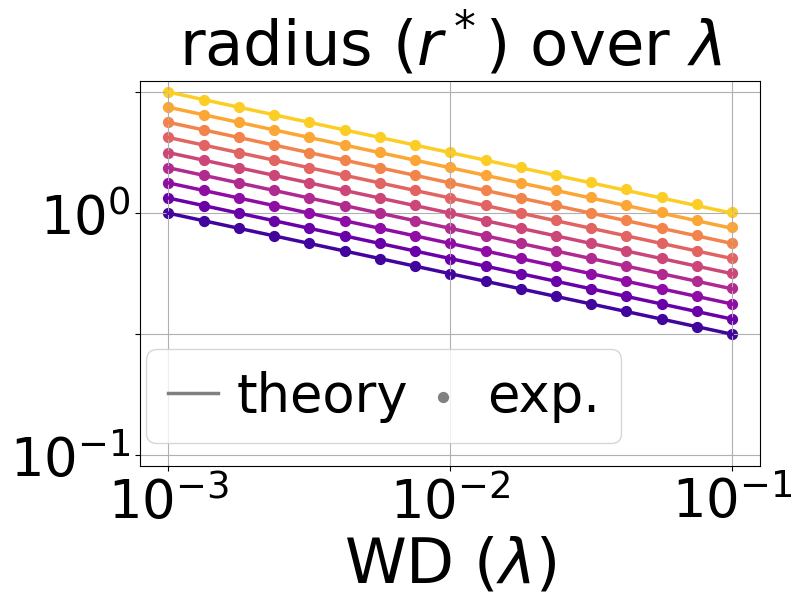

In [289]:
plt.figure(figsize=(8, 5))
plt.tight_layout()

for i in range(0, len(lrs), 2):
    lr = lrs[i]
    T_lr = T[i]
    pred_rs = (T_lr * (D - 1) / wds) ** 0.5
    plt.scatter(wds, r[i], color=lr_colors[i // 2], marker='.', s=200)
    plt.plot(wds, pred_rs, color=lr_colors[i // 2], linestyle='-', linewidth=2.5)

plt.plot([], [], linestyle='-', color='gray', label=r'theory', linewidth=2.5)
plt.scatter([], [], color='gray', marker='.', label='exp.', s=200)
plt.xscale('log')
plt.yscale('log')
#plt.annotate(text=r'$r = \sqrt[4]{\frac{\eta\sigma^2(d-1)}{2\lambda}}$', xy=(1.25e-3, 2))
plt.xticks([1e-3, 1e-2, 1e-1], ['$10^{-3}$', '$10^{-2}$', '$10^{-1}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.yticks([10 ** -1, 10 ** -0.5, 1, 10 ** 0.5], [r'$10^{-1}$', '', '$10^{0}$', ''], fontsize=38)
plt.yticks([], [], minor=True)
plt.ylim(9e-2, 3.5)
plt.xlabel(r'WD ($\lambda$)', fontsize=45)
plt.title(r'radius ($r^*$) over $\lambda$', fontsize=45, y=1.02)
plt.legend(ncol=2, fontsize=38, loc=(0.01, 0.06),
           columnspacing=0.2, handletextpad=0.35, labelspacing=0.2, handlelength=0.95)
plt.grid()
plt.savefig('images/VMF-LR-radius.png', dpi=400, bbox_inches='tight')

### Maxwell relations

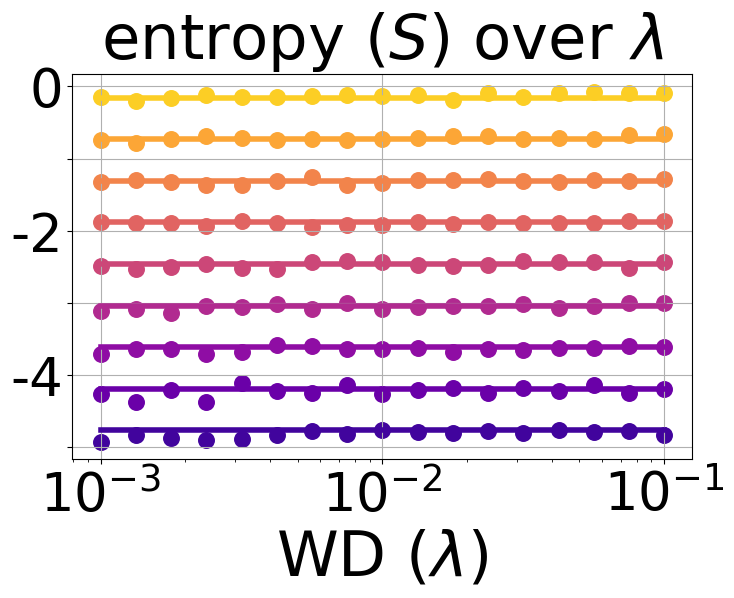

In [290]:
plt.figure(figsize=(8, 5))
plt.tight_layout()

for i in range(0, len(lrs), 2):
    lr = lrs[i]
    T_lr = T[i]
    pred_rs = (T_lr * (D - 1) / wds) ** 0.5
    pred_S = (D - 1) / 2 * (T_lr * 2 * np.pi * np.e).log() + (D - 1) * pred_rs.log()
    plt.scatter(wds, S_full[i], color=lr_colors[i // 2], marker='.', s=500)
    plt.plot(wds, pred_S, color=lr_colors[i // 2], linestyle='-', linewidth=4)

plt.xticks([1e-3, 1e-2, 1e-1], ['$10^{-3}$', '$10^{-2}$', '$10^{-1}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.xlabel(r'WD ($\lambda$)', fontsize=45)
plt.yticks(np.arange(-5, 1, 1), ['', '-4', '', '-2', '', '0'], fontsize=38)
plt.yticks([], [], minor=True)
plt.title(r'entropy ($S$) over $\lambda$', fontsize=45, y=1.02)
plt.xscale('log')
plt.grid()
plt.savefig('images/VMF-LR-entropy-wd.png', dpi=400, bbox_inches='tight')

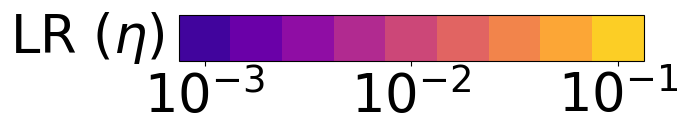

In [42]:
import matplotlib as mpl

cmap = mpl.colors.LinearSegmentedColormap.from_list("custom_plasma", lr_colors, N=len(lr_colors))
fig, ax = plt.subplots(figsize=(6, 0.6))
norm = mpl.colors.Normalize(vmin=0, vmax=len(lr_colors))
cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')
cb.set_ticks([0.5, 4.5, 8.5])
cb.set_ticklabels(['$10^{-3}$', '$10^{-2}$', '$10^{-1}$'], fontsize=38)
cb.set_label('')
ax.text(-0.03, 0.5, r'LR ($\eta$)', fontsize=38, transform=ax.transAxes,
        rotation=0, va='center', ha='right')

plt.savefig('images/VMF-LR-legend2.png', dpi=400, bbox_inches='tight')

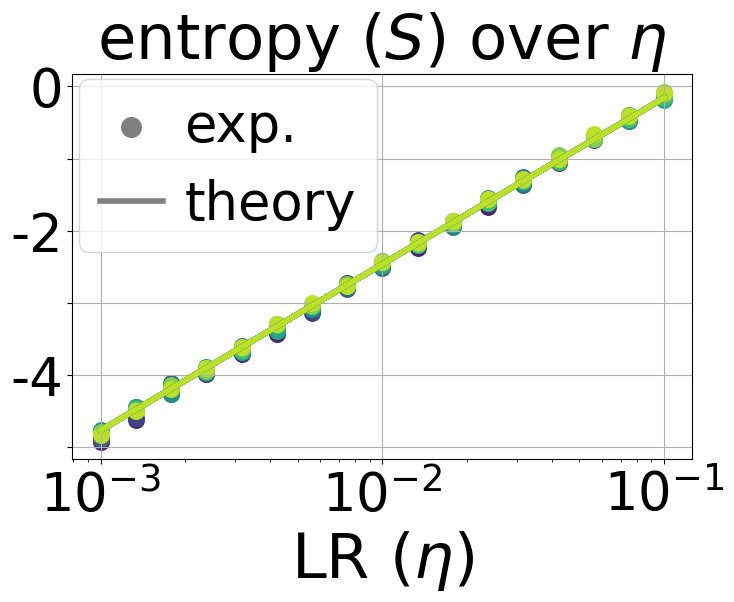

In [291]:
plt.figure(figsize=(8, 5))
plt.tight_layout()

for i in range(0, len(wds), 2):
    wd = wds[i]
    T_wd = T[:, i]
    pred_rs = (T_wd * (D - 1) / wd) ** 0.5
    pred_S = (D - 1) / 2 * (T_wd * 2 * np.pi * np.e).log() + (D - 1) * pred_rs.log()
    plt.scatter(wds, S_full[:, i], color=wd_colors[i // 2], marker='.', s=500)
    plt.plot(wds, pred_S, color=wd_colors[i // 2], linestyle='-', linewidth=4)

plt.scatter([], [], color='gray', s=200, label='exp.')
plt.plot([], [], color='gray', linewidth=4, label='theory')
plt.legend(fontsize=38, loc=(0.01, 0.54), handlelength=1.2, handletextpad=0.4)
plt.xticks([1e-3, 1e-2, 1e-1], ['$10^{-3}$', '$10^{-2}$', '$10^{-1}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.xlabel(r'LR ($\eta$)', fontsize=45)
plt.yticks(np.arange(-5, 1, 1), ['', '-4', '', '-2', '', '0'], fontsize=38)
plt.yticks([], [], minor=True)
plt.title(r'entropy ($S$) over $\eta$', fontsize=45, y=1.02)
plt.xscale('log')
plt.grid()
plt.savefig('images/VMF-LR-entropy-lr.png', dpi=400, bbox_inches='tight')

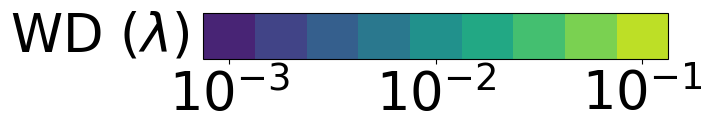

In [44]:
import matplotlib as mpl

cmap = mpl.colors.LinearSegmentedColormap.from_list("custom_viridis", wd_colors, N=len(lr_colors))
fig, ax = plt.subplots(figsize=(6, 0.6))
norm = mpl.colors.Normalize(vmin=0, vmax=len(wd_colors))
cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')
cb.set_ticks([0.5, 4.5, 8.5])
cb.set_ticklabels(['$10^{-3}$', '$10^{-2}$', '$10^{-1}$'], fontsize=38)
cb.set_label('')
ax.text(-0.03, 0.5, r'WD ($\lambda$)', fontsize=38, transform=ax.transAxes,
        rotation=0, va='center', ha='right')

plt.savefig('images/VMF-LR-legend3.png', dpi=400, bbox_inches='tight')

In [292]:
tau_coefs = torch.tensor([linear_fit(wds.log(), S_full[i])[0].item() for i in range(len(lrs))])
tau_coefs.mean(), tau_coefs.std()

(tensor(0.0131), tensor(0.0071))

In [293]:
p_coefs = torch.tensor([linear_fit(lrs.log(), S_full[:, j])[0].item() for j in range(len(wds))])
p_coefs.mean(), p_coefs.std()

(tensor(1.0139), tensor(0.0090))

In [294]:
p_coefs.mean() - tau_coefs.mean(), (D - 1) / 2

(tensor(1.0008), 1.0)

### Minimization of Gibbs potential

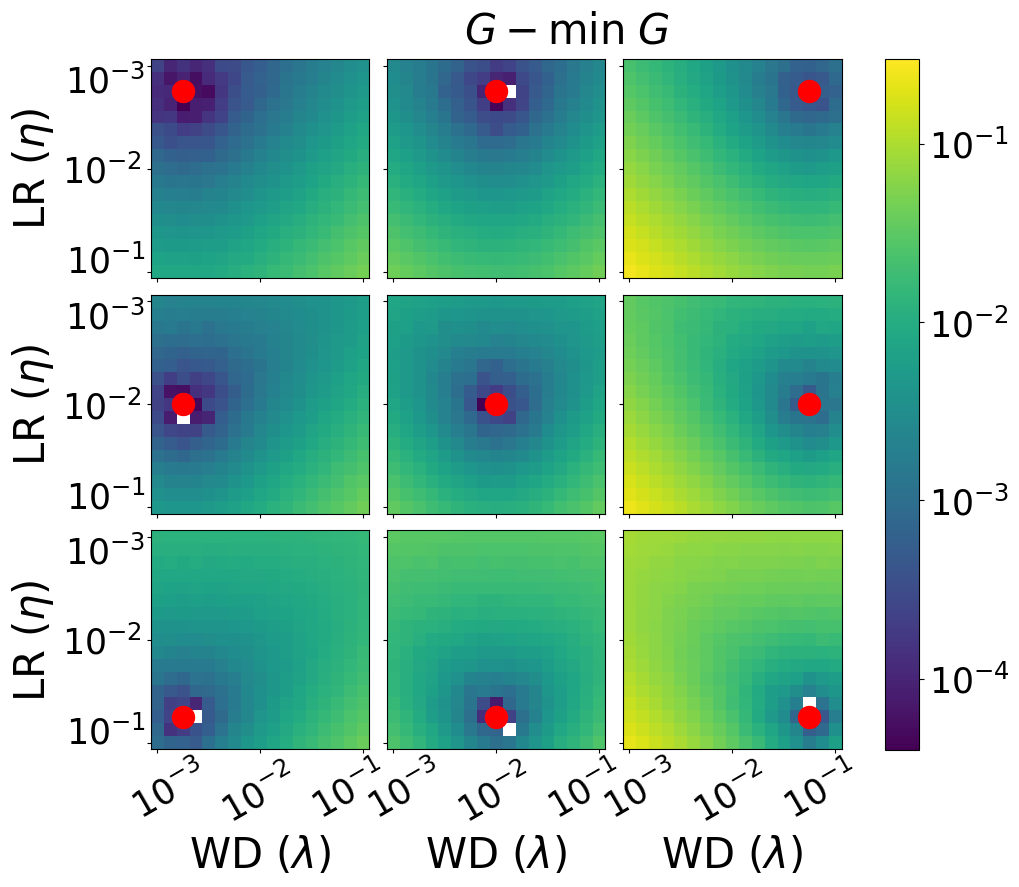

In [295]:
lr_ids, wd_ids = [2, len(lrs) // 2, len(lrs) - 3], [2, len(wds) // 2, len(wds) - 3]
fig, axs = plt.subplots(len(lr_ids), len(wd_ids), figsize=(10, 8), sharex=True, sharey=True)
plt.tight_layout()
plt.subplots_adjust(wspace=0.08, hspace=0.07)

for i, lr_id in enumerate(lr_ids):
    for j, wd_id in enumerate(wd_ids):
        G = U - T[lr_id, wd_id] * S_full + p[0, wd_id] * V
        cm = axs[i, j].imshow(G - G.min(), norm=LogNorm(vmin=4e-5, vmax=3e-1), cmap='viridis')
        axs[i, j].scatter(wd_id, lr_id, color='red', marker='o', s=250)
        #circle = plt.Circle((wd_id, lr_id), 1.5, edgecolor='red', facecolor='none', linewidth=5)
        #axs[i, j].add_artist(circle)

        step = 4
        ticks_lrs = lrs.tolist()[::step]
        ticks_wds = wds.tolist()[::step]
        #axs[i, 0].set_yticks(np.arange(0, len(lrs), step), [f'{lr:.0e}'.replace('e-0', 'e-') for lr in ticks_lrs], fontsize=20)
        #axs[-1, j].set_xticks(np.arange(0, len(wds), step), [f'{wd:.0e}'.replace('e-0', 'e-') for wd in ticks_wds], fontsize=20, rotation=60)
        axs[i, 0].set_yticks([0, 8, 16], ['', '$10^{-2}$', ''], fontsize=25)
        axs[i, 0].set_yticks([1, 15], ['$10^{-3}$', '$10^{-1}$'], minor=True, fontsize=25)
        axs[-1, j].set_xticks([0, 8, 16], ['', '$10^{-2}$', ''], fontsize=25, rotation=30)
        axs[-1, j].set_xticks([1, 15], ['$10^{-3}$', '$10^{-1}$'], minor=True, fontsize=25, rotation=30)

        axs[i, 0].set_ylabel(r'LR ($\eta$)', fontsize=30)
        axs[-1, j].set_xlabel(r'WD ($\lambda$)', fontsize=30)
        axs[i, j].tick_params(axis=u'both', which=u'minor', length=0)
        axs[i, j].tick_params(axis=u'both', which=u'major', length=3)

plt.suptitle(r'$G - \min \; G$', y=1.01, fontsize=30)
cbar = fig.colorbar(cm, ax=axs, location='right')
cbar.ax.tick_params(labelsize=25)
cbar.ax.yaxis.set_ticks([], minor=True)
plt.savefig('images/VMF-LR-potential.png', dpi=400, bbox_inches='tight')

## Fixed sphere

In [315]:
num_iters = 2000000
ent_log_freq = num_iters // 50
D = 3
queue_size, queue_freq = 1000, 50
sigma = 1
torch.manual_seed(44)
lrs = torch.logspace(-3, -1, 17)
rs = torch.logspace(-1, 1, 17)
lrs_, rs_ = torch.meshgrid(lrs, rs)
lrs_, rs_ = lrs_.reshape(-1), rs_.reshape(-1)
sigmas_ = sigma * torch.ones_like(lrs_)
wds_ = torch.zeros_like(lrs_)
mu = torch.randn(1, D)
mu /= mu.norm(dim=1, keepdim=True)

In [187]:
trace = train(
    lambda x: 1 + (mu * x).sum(dim=1) / x.norm(dim=1),
    lrs_, wds_, sigmas_, dims=D,
    num_iters=num_iters, init_norm=rs_,
    queue_size=queue_size, queue_freq=queue_freq,
    log_freq=50, ent_log_freq=ent_log_freq,
    seed=42, fix_elr=True, fix_sphere=True
)
torch.save(trace, 'trace-VMF-sphere.pt')

  0%|          | 0/2000000 [00:00<?, ?it/s]

In [316]:
trace = torch.load('trace-VMF-sphere.pt')
xs, losses, full_grads, stoch_grads, (entropies, energies, radiuses) = trace

In [317]:
ents_mean = entropies[-10:].mean(0)
U = losses[-5000:].mean(0).reshape(len(lrs), len(wds))
S = ents_mean.reshape(len(lrs), len(wds))
S_full = S + (D - 1) * rs.reshape(1, -1).log()
V = 0.5 * rs.reshape(1, -1) ** 2
T = lrs.reshape(-1, 1) * sigma ** 2 / 2
p = (xs[-5000:].norm(dim=-1).mean(dim=0) - rs_).reshape(len(lrs), len(rs)) / lrs.reshape(-1, 1) / rs.reshape(1, -1) ** 3

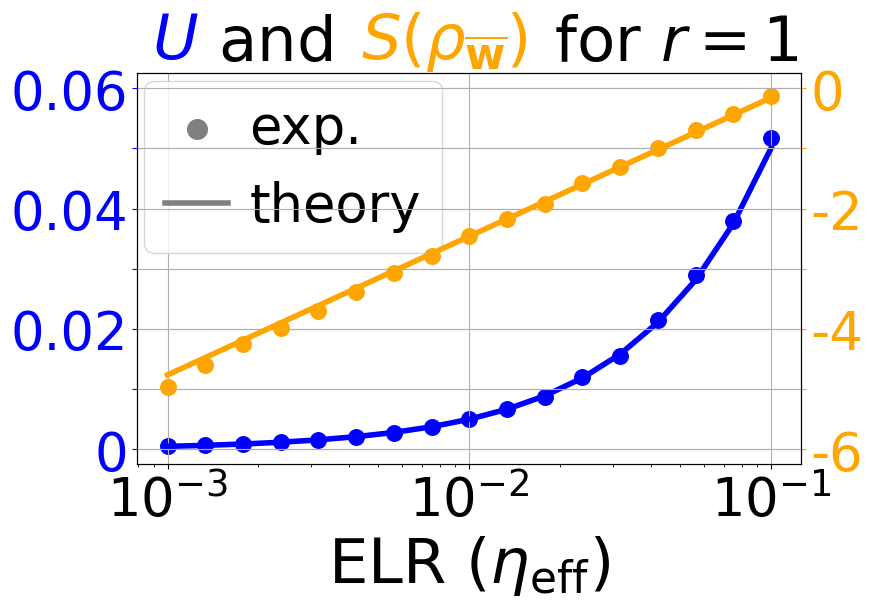

In [277]:
r_id = 8
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.tight_layout()

ax.scatter(lrs, U[:, r_id], color='blue', marker='.', s=500, label='exp.')
ax.plot(wds, (D - 1) / 2 * T[:, 0], color='blue', linewidth=4, label=r'theory')

ax2 = ax.twinx()
ax2.scatter(wds, S[:, r_id], color='orange', marker='.', s=500, label='exp.')
ax2.plot(wds, (D - 1) / 2 * (T[:, 0] * 2 * np.pi * np.e).log(), color='orange',
         linewidth=4, label=r'theory')

ax.set_xscale('log')
ax.set_xlabel(r'ELR ($\eta_{\text{eff}}$)', fontsize=45)
ax.set_xticks([10 ** -3, 10 ** -2, 10 ** -1], ['$10^{-3}$', '$10^{-2}$', '$10^{-1}$'], fontsize=38)
ax.set_yticks([0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06], ['0', '', '0.02', '', '0.04', '', '0.06'], fontsize=38)
ax.grid()
ax.tick_params(axis='y', which=u'both', colors='blue')
step = 0.01
ax.set_ylim(0 - step * 0.25, 0.06 + step * 0.25)

ax2.set_yticks([-6, -5, -4, -3, -2, -1, 0], ['-6', '', '-4', '', '-2', '', '0'], fontsize=38)
ax2.grid()
ax2.tick_params(axis='y', which=u'both', colors='orange')
step = 1
ax2.set_ylim(-6 - step * 0.25, 0 + step * 0.25)

ax.scatter([], [], color='gray', s=200, label='exp.')
ax.plot([], [], color='gray', linewidth=4, label='theory')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[-2:], labels=labels[-2:], loc=(0.01, 0.54), fontsize=38,
          handlelength=1.2, handletextpad=0.4)

ax.set_title(r'    and           for $r=1$', fontsize=45)
ax2.annotate(xy=(10**-3.05, 0.5), text=r'$U$', fontsize=45, color='blue', annotation_clip=False)
ax2.annotate(xy=(10**-2.36, 0.5), text=r'$S(\rho_{\overline{\bf{w}}})$', fontsize=45, color='orange', annotation_clip=False)
plt.savefig('images/VMF-sphere-loss-ent.png', dpi=400, bbox_inches='tight')

### Pressure prediction

In [278]:
r_colors = sns.color_palette('viridis', len(lrs) // 2 + 1)
lr_colors = sns.color_palette('plasma', len(rs) // 2 + 1)

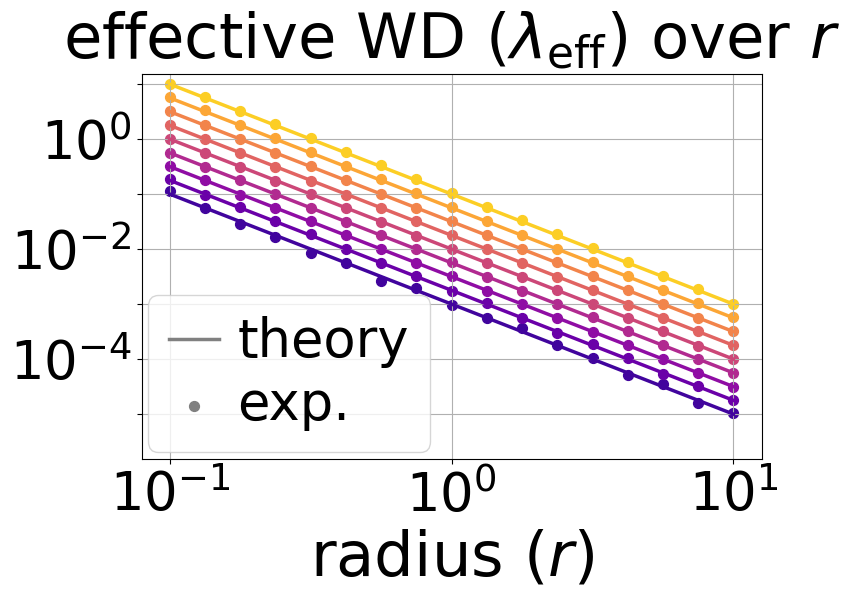

In [279]:
plt.figure(figsize=(8, 5))
plt.tight_layout()

for i in range(0, len(lrs), 2):
    lr = lrs[i]
    T_lr = T[i]
    pred_ps = T_lr * (D - 1) / rs ** 2
    plt.scatter(rs, p[i], color=lr_colors[i // 2], marker='.', s=200)
    plt.plot(rs, pred_ps, color=lr_colors[i // 2], linestyle='-', linewidth=2.5)

plt.plot([], [], linestyle='-', color='gray', label=r'theory', linewidth=2.5)
plt.scatter([], [], color='gray', marker='.', label='exp.', s=200)
plt.xscale('log')
plt.yscale('log')
plt.xticks([1e-1, 1, 1e+1], ['$10^{-1}$', '$10^{0}$', '$10^{1}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.yticks([10 ** -5, 10 ** -4, 10 **-3, 10 ** -2, 10 ** -1, 10 ** 0, 10 ** 1],
           ['', r'$10^{-4}$', '', '$10^{-2}$', '', '$10^{0}$', ''], fontsize=38)
plt.yticks([], [], minor=True)
plt.ylim(1.5e-6, 15)
plt.xlabel(r'radius ($r$)', fontsize=45)
plt.title(r'effective WD ($\lambda_{\text{eff}}$) over $r$', fontsize=45, y=1.02)
plt.legend(ncol=1, fontsize=38, loc=(0.01, 0.02),
           columnspacing=0.2, handletextpad=0.35, labelspacing=0.2, handlelength=0.95)
plt.grid()
plt.savefig('images/VMF-sphere-pressure.png', dpi=400, bbox_inches='tight')

### Entropy

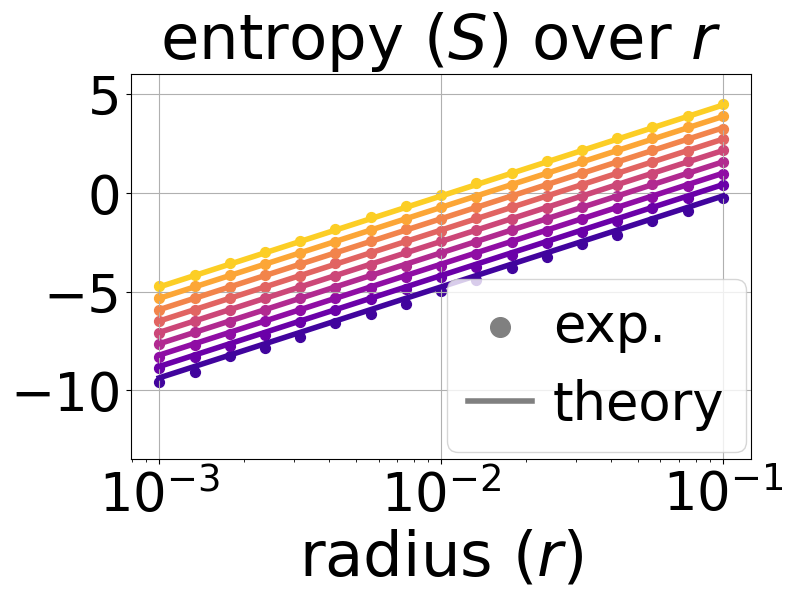

In [318]:
plt.figure(figsize=(8, 5))
plt.tight_layout()

for i in range(0, len(lrs), 2):
    lr = lrs[i]
    T_lr = T[i]
    pred_S = (D - 1) / 2 * (T_lr * 2 * np.pi * np.e).log() + (D - 1) * rs.log()
    plt.scatter(wds, S_full[i], color=lr_colors[i // 2], marker='.', s=200)
    plt.plot(wds, pred_S, color=lr_colors[i // 2], linestyle='-', linewidth=4)

plt.scatter([], [], color='gray', s=200, label='exp.')
plt.plot([], [], color='gray', linewidth=4, label='theory')
plt.legend(fontsize=38, loc=(0.51, 0.02), handlelength=1.2, handletextpad=0.4)
plt.xticks([1e-3, 1e-2, 1e-1], ['$10^{-3}$', '$10^{-2}$', '$10^{-1}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.xlabel(r'radius ($r$)', fontsize=45)
plt.yticks(np.arange(-10, 6, 5), fontsize=38)
plt.yticks([], [], minor=True)
plt.ylim(-13.5, 6)
plt.title(r'entropy ($S$) over $r$', fontsize=45, y=1.02)
plt.xscale('log')
plt.grid()
plt.savefig('images/VMF-sphere-entropy-r.png', dpi=400, bbox_inches='tight')

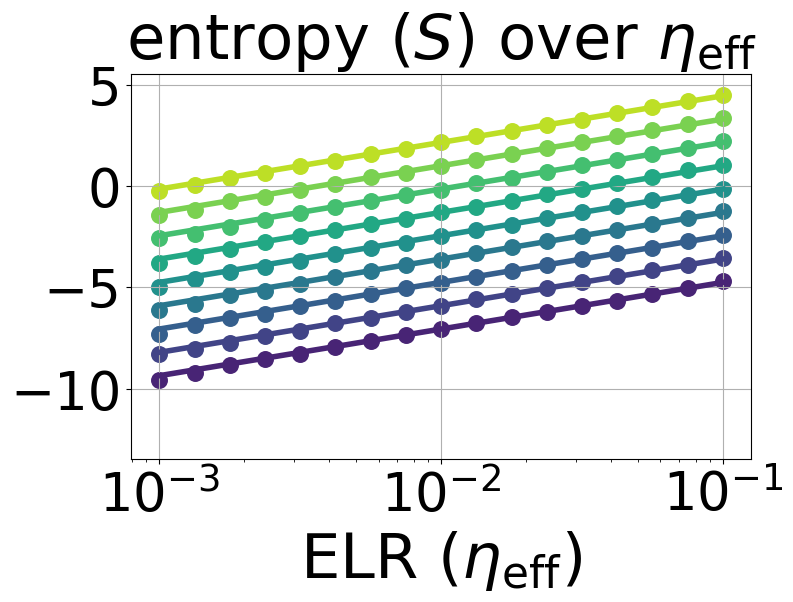

In [281]:
plt.figure(figsize=(8, 5))
plt.tight_layout()

for i in range(0, len(rs), 2):
    r = rs[i]
    T_r = T[:, 0]
    pred_S = (D - 1) / 2 * (T_wd * 2 * np.pi * np.e).log() + (D - 1) * r.log()
    plt.scatter(wds, S_full[:, i], color=r_colors[i // 2], marker='.', s=500)
    plt.plot(wds, pred_S, color=r_colors[i // 2], linestyle='-', linewidth=4)

plt.scatter([], [], color='gray', s=200, label='exp.')
plt.plot([], [], color='gray', linewidth=4, label='theory')
#plt.legend(fontsize=38, loc=(0.51, 0.02), handlelength=1.2, handletextpad=0.4)
plt.xticks([1e-3, 1e-2, 1e-1], ['$10^{-3}$', '$10^{-2}$', '$10^{-1}$'], fontsize=38)
plt.xticks([], [], minor=True)
plt.xlabel(r'ELR ($\eta_{\text{eff}}$)', fontsize=45)
plt.yticks(np.arange(-10, 6, 5), fontsize=38)
plt.ylim(-13.5, 5.5)
plt.yticks([], [], minor=True)
plt.title(r'entropy ($S$) over $\eta_{\text{eff}}$', fontsize=45, y=1.02)
plt.xscale('log')
plt.grid()
plt.savefig('images/VMF-sphere-entropy-lr.png', dpi=400, bbox_inches='tight')

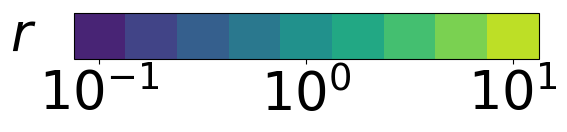

In [312]:
import matplotlib as mpl

cmap = mpl.colors.LinearSegmentedColormap.from_list("custom_viridis", r_colors, N=len(r_colors))
fig, ax = plt.subplots(figsize=(6, 0.6))
norm = mpl.colors.Normalize(vmin=0, vmax=len(r_colors))
cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='horizontal')
cb.set_ticks([0.5, 4.5, 8.5])
cb.set_ticklabels(['$10^{-1}$', '$10^{0}$', '$10^{1}$'], fontsize=38)
cb.set_label('')
ax.text(-0.08, 0.5, r'$r$', fontsize=38, transform=ax.transAxes,
        rotation=0, va='center', ha='right')

plt.savefig('images/VMF-sphere-legend.png', dpi=400, bbox_inches='tight')

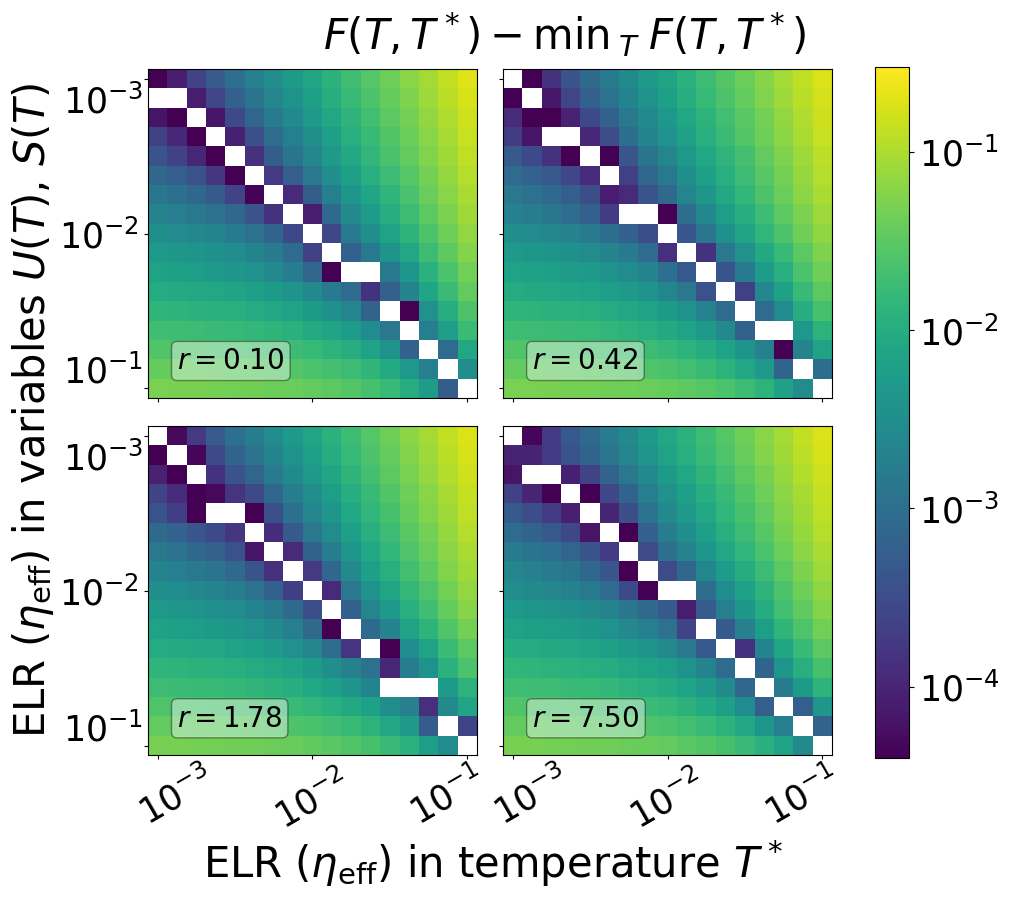

In [282]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
plt.tight_layout()
plt.subplots_adjust(wspace=0.08, hspace=0.07)
r_ids = [0, 5, 10, 15]

for j, r_id in enumerate(r_ids):
    ax = axs.flatten()[j]
    F = U[:, r_id:r_id + 1] - T.reshape(1, -1) * S_full[:, r_id:r_id + 1]
    cm = ax.imshow(F - F.min(dim=0).values, norm=LogNorm(vmin=4e-5, vmax=3e-1), cmap='viridis')
    ax.annotate(text=f'$r={rs[r_id].item():.2f}$', xy=(1, 15),
                bbox=dict(facecolor='white', alpha=0.4, edgecolor='black', boxstyle='round,pad=0.2'))

for i in range(2):
    axs[i, 0].set_yticks([0, 8, 16], ['', '$10^{-2}$', ''], fontsize=25)
    axs[i, 0].set_yticks([1, 15], ['$10^{-3}$', '$10^{-1}$'], minor=True, fontsize=25)
    axs[-1, i].set_xticks([0, 8, 16], ['', '$10^{-2}$', ''], fontsize=25, rotation=30)
    axs[-1, i].set_xticks([1, 15], ['$10^{-3}$', '$10^{-1}$'], minor=True, fontsize=25, rotation=30)

for ax in axs.flatten():
    ax.tick_params(axis=u'both', which=u'minor', length=0)
    ax.tick_params(axis=u'both', which=u'major', length=3)

axs[-1, 0].set_ylabel(r'ELR ($\eta_{\text{eff}}$) in variables $U(T)$, $S(T)$', fontsize=30)
axs[-1, 0].set_xlabel(r'ELR ($\eta_{\text{eff}}$) in temperature $T^*$', fontsize=30)
axs[-1, 0].yaxis.set_label_coords(-0.28, 1.05)
axs[-1, 0].xaxis.set_label_coords(1.05, -0.25)

plt.suptitle(r'$F(T, T^*) - \min \,_T \; F(T, T^*)$', y=1.02, fontsize=30)
cbar = fig.colorbar(cm, ax=axs, location='right')
cbar.ax.tick_params(labelsize=25)
cbar.ax.yaxis.set_ticks([], minor=True)
plt.savefig('images/VMF-sphere-potential.png', dpi=400, bbox_inches='tight')